<h1>Sentiment Analysis and Text Classification on Reddit Comments</h1>
<h2>Problem definition</h2>
<p>Analyzing comments in social media platforms like Reddit. Reddit offers a free API which provides rich text data on how people perceive topics of interest.</p>
<p>For this project, the goal is to classify Reddit comments in the sub reddit &ldquo;anime&rdquo; and the topic &ldquo;hunter x hunter&rdquo; into positive or negative sentiments.</p>
<p>After adding label to each comment using a pre-trained model named "Pysentimiento", a text classification model will be created. In the end a evaluation of metrics will be included</p>
<p>This problem is framed as a &ldquo;Sentiment Analysis and Text Classification&rdquo; task using NLP techniques to label a comment as positive or negative.</p>


<h2>Sentiment Analysis and Text Classification Pipeline</h2>
<p>The pipeline consists of the following components:</p>
<ol style="font-size: 20px;">
    <li>Data collection:
        <ol style="list-style-type: lower-alpha; font-size: 18px;">
            <li>Connect to the Reddit API using &ldquo;praw&rdquo; to extract comments related to a specific subreddit and topic.</li>
            <li>Store the extracted comments in a dataframe.</li>
        </ol>
    </li>
    <li>Data preprocessing:
        <ol style="list-style-type: lower-alpha; font-size: 18px;">
            <li>Clean the comments:
                <ol style="list-style-type: lower-roman; font-size: 16px;">
                    <li>Removing URLs</li>
                    <li>Removing special characters and numbers</li>
                    <li>Convert to lower case</li>
                    <li>Tokenize</li>
                    <li>Remove stop words</li>
                    <li>Lemmatization</li>
                </ol>
            </li>
            <li>Create a column called "processed_comment_body" with the cleaned text</li>
        </ol>
    </li>
</ol>
<ol start="3" style="font-size: 20px;">
    <li>Data Labeling:
        <ol style="list-style-type: lower-alpha; font-size: 18px;">
            <li>Use &ldquo;pysentimiento&rdquo; to label the comments as (POS: positive, NEU: neutral, NEG: negative).</li>
            <li>Create a label column named &ldquo;output&rdquo; that contains the label using pysentimiento</li>
            <li>Drop the rows labeled as &ldquo;NEU&rdquo; (neutral) and convert the positive ones into 1 and the negative ones into 0.</li>
        </ol>
    </li>
    <li>Modelling:
        <ol style="list-style-type: lower-alpha; font-size: 18px;">
            <li>Machine learning:
                <ol style="list-style-type: lower-roman; font-size: 16px;">
                    <li>Create a Random Forest classifier using SMOTE techniques to balance the target classes.</li>
                </ol>
            </li>
            <li>Deep Learning:
                <ol style="list-style-type: lower-roman; font-size: 16px;">
                    <li>Implement a LSTM-based model with embeddings for a better semantic performance.</li>
                </ol>
            </li>
        </ol>
    </li>
    <li>Evaluation:
        <ol style="list-style-type: lower-alpha; font-size: 18px;">
            <li>Evaluate models using the following metrics:
                <ol style="list-style-type: lower-roman; font-size: 16px;">
                    <li>Precision</li>
                    <li>Recall</li>
                    <li>F1-Score</li>
                    <li>Confusion Matrix</li>
                </ol>
            </li>
            <li>Compare the performances between Random Forest and Deep Learning (LSTM based)</li>
        </ol>
    </li>
</ol>
<ol start="6" style="font-size: 20px;">
    <li>Pipeline Summary:</li>
</ol>
<h3>Data Collection -&gt; Preprocessing -&gt; Labeling -&gt; Modelling -&gt; Evaluation</h3>


#### Libraries and Packages


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import praw
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from pysentimiento import create_analyzer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam

#### Data collection


<p>To get the secrets to connect to Reddit API, some process needs to be done. Consult this <a href="https://praw.readthedocs.io/en/latest/index.html">link</a> where all the documentation and information regarding &ldquo;praw&rdquo; is available.</p>


In [ ]:
user_agent = "Pyscraper 1.0 by /u/Due_Sand_8938"
client_id = "lI7rbjuiFhTvw7AtOaengA"
client_secret = "jTEZzqXh8BnVd8uqllu7jI1udh5HKg"

reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
)

The following function: subreddit_to_dataset is defined to obtain a dataset with comments related to a specific topic within a subreddit.


In [ ]:
def subreddit_to_dataset(subredditName, topicName, limitePosts=10):
    comments_data = []
    for submission in reddit.subreddit(subredditName).search(topicName, limit=limitePosts, sort="top"):
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            comments_data.append({
                "post_id": submission.id,
                "post_title": submission.title,
                "post_created_utc" : submission.created_utc,
                "post_num_comments" : submission.num_comments,
                "comment_id": comment.id,
                "comment_body": comment.body,
                "comment_author": str(comment.author),
                "comment_score": comment.score,
                "comment_created_utc": comment.created_utc
            })

    df_comments = pd.DataFrame(comments_data)
    return df_comments

The subreddit chosen is "anime". The anime community in Reddit is very big and a lot of text information can be found there. In particular, this project will focus on "hunter x hunter" one of the most popular animes ever.


In [ ]:
subreddit_name = "anime"
topic_name = "hunter x hunter"

In [ ]:
df = subreddit_to_dataset(subredditName=subreddit_name, topicName=topic_name, limitePosts=50)

In [9]:
df.shape

(15121, 2)

In [8]:
df = df[['comment_id', 'comment_body']]

In [10]:
df.head()

,comment_id,comment_body
0,ldtcd1x,I remember the first one got absolutely evisce...
1,ldtdi0t,Feels like everyone wants to make beginner cha...
2,ldtm86n,So many people putting Bocchi into SoL when it...
3,ldtfa1a,Any anime can be a beginner anime if it’s the ...
4,ldtjvas,I wish they animated more of Black Lagoon.


#### Data Preprocessing


In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/robertoberrocal/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


The following fuction: preprocess_text is defined to preprocess the text data, covering steps like: removing urls, remove special characters, remove numbers, convert text to lower case, remove stop words in English and apply lemmatization


In [ ]:
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W+|\d+', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

In [ ]:
df['processed_comment_body'] = df['comment_body'].apply(preprocess_text)

df.head()

/var/folders/wh/t4t79wp51pq2p1t_bfnc30t80000gn/T/ipykernel_73036/1892080687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_comment_body'] = df['comment_body'].apply(preprocess_text)


,comment_id,comment_body,processed_comment_body
0,ldtcd1x,I remember the first one got absolutely evisce...,remember first one got absolutely eviscerated lol
1,ldtdi0t,Feels like everyone wants to make beginner cha...,feel like everyone want make beginner chart on...
2,ldtm86n,So many people putting Bocchi into SoL when it...,many people putting bocchi sol primary genre c...
3,ldtfa1a,Any anime can be a beginner anime if it’s the ...,anime beginner anime first one watch
4,ldtjvas,I wish they animated more of Black Lagoon.,wish animated black lagoon


#### Data Labeling


In [ ]:
analyzer = create_analyzer(task="sentiment", lang="en", tqdm_bar=False)

In [16]:
df['output'] = df['processed_comment_body'].apply(lambda x: analyzer.predict(x).output)

/var/folders/wh/t4t79wp51pq2p1t_bfnc30t80000gn/T/ipykernel_73036/3416406285.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['output'] = df['processed_comment_body'].apply(lambda x: analyzer.predict(x).output)


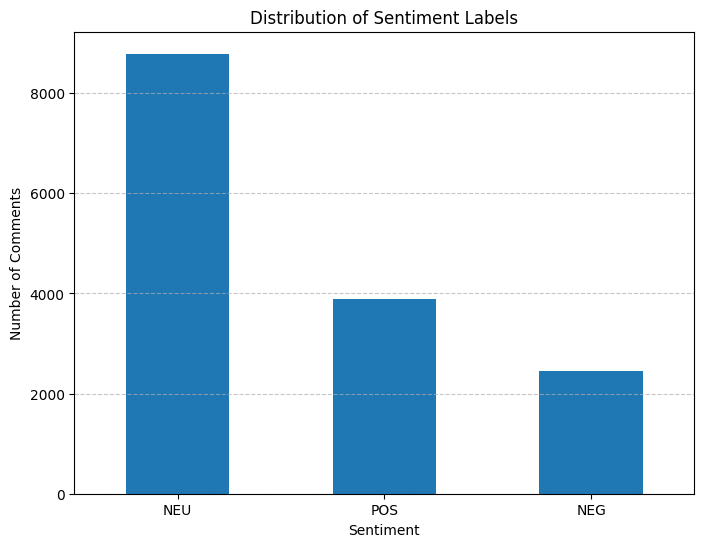

In [ ]:
sentiment_counts = df['output'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
df['output'].value_counts()

output
NEU    8790
POS    3881
NEG    2450
Name: count, dtype: int64

Take the decision to drop the "NEU" class, to work only with the "POS" and "NEG" classes. After that, label "POS" class as 1 and "NEG" class as 0


In [ ]:
df_binary = df[df['output'] != 'NEU']

In [22]:
df_binary['output'] = df_binary['output'].apply(lambda x: 1 if x == 'POS' else 0)

/var/folders/wh/t4t79wp51pq2p1t_bfnc30t80000gn/T/ipykernel_73036/1776690980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['output'] = df_binary['output'].apply(lambda x: 1 if x == 'POS' else 0)


In [23]:
df_binary['output'].value_counts()

output
1    3881
0    2450
Name: count, dtype: int64

The dataframe is converted into a .csv file to avoid requesting to the Reddit API each time this notebook is run


In [25]:
df_binary.to_csv("hunter_x_hunter_comments_with_sentiment.csv", index=False)

In [27]:
df_binary.head()

,comment_id,comment_body,processed_comment_body,output
6,ldtfetl,I don’t feel it is particularly safe to recomm...,feel particularly safe recommend pure fun anim...,1
7,ldtu1fn,"Not a bad list, but there are far too many unf...",bad list far many unfinished show imo think de...,0
8,ldtfux0,Nozaki is interesting. I feel like it's probab...,nozaki interesting feel like probably better a...,1
9,ldts9t9,No Silent Voice in drama? Other than that most...,silent voice drama mostly great list,1
13,ldtk14j,"I'm sorry, I know everyone here is very nostal...",sorry know everyone nostalgic toradora love sh...,0


#### Modelling


##### Random Forest


In [ ]:
X = df_binary['processed_comment_body']
y = df_binary['output']

X_train, X_test, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

When working with text data, is important to convert it into numerical variables. TF-IDF is used here


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In the chart above, excluding the "NEU" class, is noticeable that the dataset contains more "POS" comments than "NEG". So, SMOTE technique will be applied to balance both classes


In [ ]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train_rf)

/opt/anaconda3/envs/nlp_env/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp_env/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_balanced, y_train_balanced)

y_pred_rf = random_forest_model.predict(X_test_tfidf)

In [67]:
classification_rep = classification_report(y_test_rf, y_pred_rf)
confusion_mat = confusion_matrix(y_test_rf, y_pred_rf)

print("Classification Report - Random Forest Model:")
print(classification_rep)
print("\nConfusion Matrix - Random Forest Model:")
print(confusion_mat)

Classification Report - Random Forest Model:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       484
           1       0.85      0.90      0.87       783

    accuracy                           0.84      1267
   macro avg       0.84      0.82      0.83      1267
weighted avg       0.84      0.84      0.84      1267


Confusion Matrix - Random Forest Model:
[[360 124]
 [ 78 705]]


##### LSTM Neural Network


For this LSTM Neural network model, after splitting data into train and test, text data is tokenized and converted into sequences


In [ ]:
X = df_binary['processed_comment_body']
y = df_binary['output'].values

X_train, X_test, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

Set the LSTM model:


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/opt/anaconda3/envs/nlp_env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history = model.fit(X_train_pad, y_train_lstm, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype("int32")

Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6254 - loss: 0.6537 - val_accuracy: 0.8075 - val_loss: 0.4199
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.8828 - loss: 0.2993 - val_accuracy: 0.8450 - val_loss: 0.3740
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9622 - loss: 0.1011 - val_accuracy: 0.8648 - val_loss: 0.4293
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9901 - loss: 0.0364 - val_accuracy: 0.8648 - val_loss: 0.5667
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.9949 - loss: 0.0135 - val_accuracy: 0.8539 - val_loss: 0.7222
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.9977 - loss: 0.0062 - val_accuracy: 0.8450 - val_loss: 0.9119
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9975 - loss: 0.0079 - val_accuracy: 0.8490 - val_loss: 0.9713
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9962 - loss: 0.0135 - val_accu

In [68]:
print("Classification Report: LSTM Neural Network")
print(classification_report(y_test_lstm, y_pred_lstm))
print("\nConfusion Matrix: LSTM Neural Network")
print(confusion_matrix(y_test_lstm, y_pred_lstm))

Classification Report: LSTM Neural Network
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       484
           1       0.86      0.91      0.89       783

    accuracy                           0.86      1267
   macro avg       0.85      0.84      0.84      1267
weighted avg       0.86      0.86      0.85      1267


Confusion Matrix: LSTM Neural Network
[[371 113]
 [ 69 714]]


#### Evaluation


In [ ]:
rf_classification_report = classification_report(y_test_rf, y_pred_rf, output_dict=True)
lstm_classification_report = classification_report(y_test_lstm, y_pred_lstm, output_dict=True)

metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (Class 0)", "Recall (Class 0)", "F1-Score (Class 0)",
               "Precision (Class 1)", "Recall (Class 1)", "F1-Score (Class 1)"],
    "Random Forest": [
        rf_classification_report["accuracy"],
        rf_classification_report["0"]["precision"],
        rf_classification_report["0"]["recall"],
        rf_classification_report["0"]["f1-score"],
        rf_classification_report["1"]["precision"],
        rf_classification_report["1"]["recall"],
        rf_classification_report["1"]["f1-score"]
    ],
    "LSTM Neural Network": [
        lstm_classification_report["accuracy"],
        lstm_classification_report["0"]["precision"],
        lstm_classification_report["0"]["recall"],
        lstm_classification_report["0"]["f1-score"],
        lstm_classification_report["1"]["precision"],
        lstm_classification_report["1"]["recall"],
        lstm_classification_report["1"]["f1-score"]
    ]
})

print(metrics_df)

                Metric  Random Forest  LSTM Neural Network
0             Accuracy       0.840568             0.856354
1  Precision (Class 0)       0.821918             0.843182
2     Recall (Class 0)       0.743802             0.766529
3   F1-Score (Class 0)       0.780911             0.803030
4  Precision (Class 1)       0.850422             0.863362
5     Recall (Class 1)       0.900383             0.911877
6   F1-Score (Class 1)       0.874690             0.886957


In [ ]:
confusion_rf = confusion_matrix(y_test_rf, y_pred_rf)
confusion_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)

confusion_rf_df = pd.DataFrame(confusion_rf, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])
confusion_lstm_df = pd.DataFrame(confusion_lstm, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])

print("Confusion Matrix - Random Forest:")
print(confusion_rf_df)
print("\nConfusion Matrix - LSTM Neural Network:")
print(confusion_lstm_df)


Confusion Matrix - Random Forest:
          Predicted 0  Predicted 1
Actual 0          360          124
Actual 1           78          705

Confusion Matrix - LSTM Neural Network:
          Predicted 0  Predicted 1
Actual 0          371          113
Actual 1           69          714


<h2>Evaluations and Results</h2>
<ol style="font-size: 18px;">
    <li>Random Forest
        <ol style="list-style-type: lower-alpha; font-size: 16px;">
            <li>Advantages:
                <ol style="list-style-type: lower-roman; font-size: 14px;">
                    <li>Simpler and faster to train</li>
                    <li>Good recall and F1-score for the class 1 (“positive”) (90.04% and 87.47% respectively)</li>
                </ol>
            </li>
            <li>Disadvantages:
                <ol style="list-style-type: lower-roman; font-size: 14px;">
                    <li>Lower recall for the negative class (74.38%)</li>
                    <li>Struggles a bit with the imbalances of the classes</li>
                </ol>
            </li>
        </ol>
    </li>
    <li>LSTM Neural Networks
        <ol style="list-style-type: lower-alpha; font-size: 16px;">
            <li>Advantages:
                <ol style="list-style-type: lower-roman; font-size: 14px;">
                    <li>Better accuracy (85.63%) compared to Random Forest</li>
                    <li>Performs better with the recall and F1-score for both classes</li>
                </ol>
            </li>
            <li>Disadvantages:
                <ol style="list-style-type: lower-roman; font-size: 14px;">
                    <li>Needs more computational power than Random Forest</li>
                    <li>More time to train and do the hyperparameter tuning step</li>
                </ol>
            </li>
        </ol>
    </li>
</ol>


<h3>Conclusions and Recommendations</h3>
<ol style="font-size: 18px;">
    <li>Conclusions:
        <ol style="list-style-type: lower-alpha; font-size: 16px;">
            <li>Random Forest is a good machine learning model to take as a start point of possible future experiments.</li>
            <li>LSTM Neural Networks. A deep learning model that handles sequential data very well. Is more complex than Random Forest.</li>
            <li>Obtained a high accuracy for both models. LSTM had slightly better metrics than Random Forest.</li>
            <li>Is important to mention that, this comments data are written by people, it may contain grammatical errors, punctiation errors, typos, etc. So a better cleaning and pre processing text could lead to better performance</li>
        </ol>
    </li>
    <li>Limitations:
        <ol style="list-style-type: lower-alpha; font-size: 16px;">
            <li>Despite having class imbalance, SMOTE techniques were applied to handle it, but the recall for the class negative is still low.</li>
            <li>As the neutral class was dropped, the dataset size might be a limitation for the LSTM model to use the full potential for detecting complex relationships.</li>
            <li>Computing costs might represent a limitation cause deep learning models require more computational power and processing time.</li>
        </ol>
    </li>
    <li>Recommendations:
        <ol style="list-style-type: lower-alpha; font-size: 16px;">
            <li>Collect more data to improve model metrics and think about evaluating “sentiments” such as: happy, sad, angry.</li>
            <li>Use others pre-trained models to get different labels and evaluate which one performs better in the evaluation step, after modelling. </li>
            <li>Try to include transformer-based models like BERT or DistilBERT for labelling if the resources are enough.</li>
            <li>Use some embedding tools like GloVe or Word2Vec to enhance semantic representation in the LSTM Neural Network model.</li>
            <li>Try less complex machine learning models and more complex deep learning architecutres. A hyper-parameter tunning step would help to increase performance</li>
        </ol>
    </li>
</ol>
